# オートエンコーダー（一般画像）
* アニメ顔とかのオートエンコーダーを作ってみる
* 中間層にKL正規化項を入れ、変分AEにしている
* ネットワークはConvolution - Deconcolutionネットワークを使う

In [2]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd
from PIL import Image
from StringIO import StringIO
import math

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence

import six

import matplotlib.pyplot as plt

# chainer exampleに付属のdata.pyをimportする. mnistのダウンロードのため
import data

## GPU設定

In [3]:
gpu_flag = 0
if gpu_flag >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_flag >= 0 else np

## データのロード

In [12]:
# img_size
size = 96
# image path
image_dir = "./images/anime_face"
#image_dir = "./images/sample/"
# load images
fs = os.listdir(image_dir)
dataset = []
for fn in fs:
    f = open('%s/%s'%(image_dir,fn), 'rb')
    img_bin = f.read()
    img = np.asarray(Image.open(StringIO(img_bin)).convert('L')).astype(np.float32)
    img = img.reshape(1, img.shape[0], img.shape[1])
    dataset.append(img)
    f.close()
dataset = np.asarray(dataset)
print("num_of_images : %s"%dataset.shape[0])

## 画素が（-1~1）の範囲に収まるように調整する関数の定義
def clip_img(x):
    return np.float32(-1 if x<(-1) else (1 if x>1 else x))

num_of_images : 10000


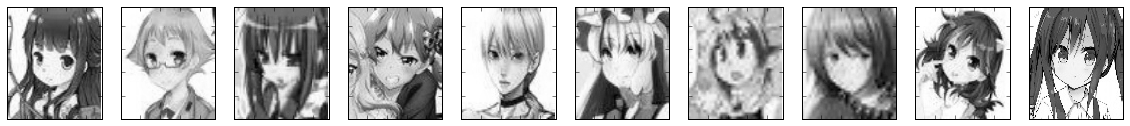

In [29]:
def draw_img_mc(data, size=96):
    size = size
    n = data.shape[0]
    plt.figure(figsize=(n*2, 2))
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(1, n, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]             # flip vertical
        plt.xlim(0,size)
        plt.ylim(0,size)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
def draw_img_rgb(data):
    size = 96
    n = data.shape[0]
    plt.figure(figsize=(n*2, 2))
    data /= data.max()
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(1, n, cnt)
        tmp = data[idx,:,:,:].transpose(1,2,0)
        plt.imshow(tmp)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
draw_img_mc( dataset[np.random.permutation( dataset.shape[0] )[:10]] )

In [15]:
N = dataset.shape[0]
train_rate = 0.7
N_train = int(N*train_rate)
N_test = N - N_train
print('N_dataset={}, N_train={}, N_test={}'.format(N, N_train, N_test))

# 正規化(0~1に)
dataset /= 255
# 訓練データとテストデータに分割
x_train, x_test = np.split(dataset,   [N_train])
print x_train.shape

N_dataset=10000, N_train=7000, N_test=3000
(7000, 1, 96, 96)


## 学習パラメータの設定

In [16]:
batchsize = 100 # ミニバッチのサイズ
n_epoch = 20     # epoch数
n_latent = 100   # 潜在変数の次元(DCGANで言うところのプライヤーベクトルの次元)
beta = 1.0   # KL正則化項の重み
conv_size = 512  # convolution層の最大チャネルサイズ

# Optimizer(Adam)
al = 0.001
b1 = 0.9
b2 = 0.999

## モデルの定義

In [17]:
class VAE(chainer.Chain):
    """AutoEncoder"""
    def __init__(self, n_latent=100, input_size=96, input_ch=3, output_ch=512):
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.input_size = input_size
        self.out_size = input_size/(2**4)
        super(VAE, self).__init__(
            ## ネットワーク構造の定義
            # encoder
            c0 = L.Convolution2D(self.input_ch, self.output_ch/8, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.input_ch)),
            c1 = L.Convolution2D(self.output_ch/8, self.output_ch/4, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/8)),
            c2 = L.Convolution2D(self.output_ch/4, self.output_ch/2, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/4)),
            c3 = L.Convolution2D(self.output_ch/2, self.output_ch, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/2)),
            l4_mu = L.Linear(self.out_size*self.out_size*self.output_ch, n_latent, wscale=0.02*math.sqrt(self.out_size*self.out_size*self.output_ch)),
            l4_var = L.Linear(self.out_size*self.out_size*self.output_ch, n_latent, wscale=0.02*math.sqrt(self.out_size*self.out_size*self.output_ch)),
            bne0 = L.BatchNormalization(self.output_ch/8),
            bne1 = L.BatchNormalization(self.output_ch/4),
            bne2 = L.BatchNormalization(self.output_ch/2),
            bne3 = L.BatchNormalization(self.output_ch),
            # decoder
            l0z = L.Linear(n_latent, self.out_size*self.out_size*self.output_ch, wscale=0.02*math.sqrt(n_latent)),
            dc1 = L.Deconvolution2D(self.output_ch, self.output_ch/2, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch)),
            dc2 = L.Deconvolution2D(self.output_ch/2, self.output_ch/4, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/2)),
            dc3 = L.Deconvolution2D(self.output_ch/4, self.output_ch/8, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/4)),
            dc4 = L.Deconvolution2D(self.output_ch/8, self.input_ch, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/8)),
            bnd0l = L.BatchNormalization(self.out_size*self.out_size*self.output_ch),
            bnd0 = L.BatchNormalization(self.output_ch),
            bnd1 = L.BatchNormalization(self.output_ch/2),
            bnd2 = L.BatchNormalization(self.output_ch/4),
            bnd3 = L.BatchNormalization(self.output_ch/8),
        )

    def __call__(self, x, sigmoid=True):
        """AutoEncoder"""
        # 下記、encodeとdecodeの中身をこの中に書いても良いがencodeとｄｅｃｏｄｅは他でも使うので再利用性を高めるために
        return self.decode(self.encode(x)[0], sigmoid)

    def encode(self, x, test=False):
        # 推論モデル, 中間表現のベクトルqを学習
        h = F.relu(self.bne0(self.c0(x)))
        h = F.relu(self.bne1(self.c1(h), test=test))
        h = F.relu(self.bne2(self.c2(h), test=test))
        h = F.relu(self.bne3(self.c3(h), test=test))
        mu = (self.l4_mu(h))
        var = (self.l4_var(h))
        return mu, var

    def decode(self, z, sigmoid=True, test=False):
        # 中間表現ベクトルqを入力として(z), 画像を生成
        h = F.reshape(F.relu(self.bnd0l(self.l0z(z), test=test)), (z.data.shape[0], self.output_ch, self.out_size, self.out_size))
        h = F.relu(self.bnd1(self.dc1(h), test=test))
        h = F.relu(self.bnd2(self.dc2(h), test=test))
        h = F.relu(self.bnd3(self.dc3(h), test=test))
        x = (self.dc4(h))
        if sigmoid:
            return F.sigmoid(x)
        else:
            return x

    def get_loss_func(self, C=1.0, k=1, train=True):
        """Get loss function of VAE.
        Args:
            C (int): Usually this is 1.0. Can be changed to control the
                second term of ELBO bound, which works as regularization.
            k (int): Number of Monte Carlo samples used in encoded vector.
            train (bool): If true loss_function is used for training.
        """
        def lf(x):
            mu, ln_var = self.encode(x)
            batchsize = len(mu.data)
            # reconstruction loss
            rec_loss = 0
            for l in six.moves.range(k):
                z = F.gaussian(mu, ln_var)
                rec_loss += F.bernoulli_nll(x, self.decode(z, sigmoid=False)) / (k * batchsize)
                #rec_loss += F.mean_squared_error(x, self.decode(z)) / (k)
            self.rec_loss = rec_loss
            # reguralization
            self.loss = self.rec_loss + C * gaussian_kl_divergence(mu, ln_var) / batchsize
            return self.loss
        return lf

## Optimizerの設定

In [18]:
# モデルの設定
model = VAE(input_ch=1, input_size=size, n_latent=n_latent, output_ch=conv_size)
if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    model.to_gpu()
xp = np if gpu_flag < 0 else cuda.cupy

# Optimizerを定義する
optimizer = optimizers.Adam(alpha=al, beta1=b1, beta2=b2)
optimizer.setup(model)

## 訓練の実行

In [19]:
loss_arr = []
recloss_arr = []
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)
    
    # training
    ## 訓練データのsampler
    perm = np.random.permutation(N_train)
    ## lossのbuffer
    sum_loss = 0       # total loss
    sum_rec_loss = 0   # reconstruction loss
    ## バッチ学習
    for i in six.moves.range(0, N_train, batchsize):
        x = chainer.Variable(xp.asarray(x_train[perm[i:i + batchsize]])) # バッチ分のデータの抽出
        
        model.zerograds()
        loss = model.get_loss_func(C=beta)(x)
        loss.backward()
        optimizer.update()
        
        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)

    print('train mean loss={}, mean reconstruction loss={}'.format(sum_loss / N, sum_rec_loss / N))
    loss_arr.append(float(sum_loss)/N_train)
    recloss_arr.append(float(sum_rec_loss)/N_train)

('epoch', 1)
train mean loss=4314.9127002, mean reconstruction loss=3807.07837402
('epoch', 2)
train mean loss=3768.14097656, mean reconstruction loss=3596.54543457
('epoch', 3)
train mean loss=3671.51850098, mean reconstruction loss=3556.29734375
('epoch', 4)
train mean loss=3626.77612793, mean reconstruction loss=3534.62294922
('epoch', 5)
train mean loss=3600.85101562, mean reconstruction loss=3516.38214355
('epoch', 6)
train mean loss=3587.62467773, mean reconstruction loss=3504.65581543
('epoch', 7)
train mean loss=3577.59100098, mean reconstruction loss=3494.71662598
('epoch', 8)
train mean loss=3569.94788086, mean reconstruction loss=3486.88098633
('epoch', 9)
train mean loss=3559.76339355, mean reconstruction loss=3477.13933105
('epoch', 10)
train mean loss=3555.45899902, mean reconstruction loss=3472.64638672
('epoch', 11)
train mean loss=3554.32239258, mean reconstruction loss=3470.23291992
('epoch', 12)
train mean loss=3544.87092773, mean reconstruction loss=3461.72841309
('

## 結果の可視化

[]

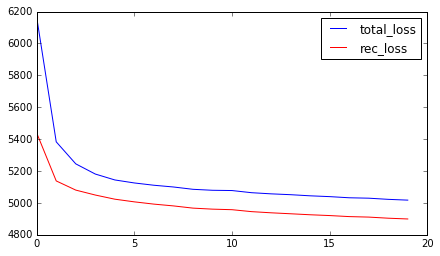

In [20]:
plt.figure(figsize=(7, 4))
plt.plot(range(len(loss_arr)), loss_arr, color="#0000FF", label="total_loss")
plt.plot(range(len(recloss_arr)), recloss_arr, color="#FF0000", label="rec_loss")
plt.legend()
plt.plot()

[5966 6581 1309 4636 3386 6091 1978  423 1034 1218]
input image


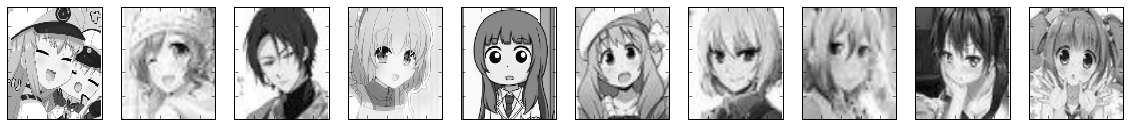

reconstruction image


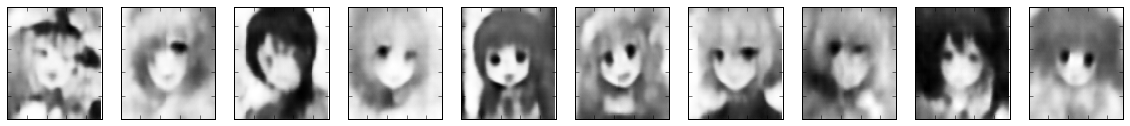

In [22]:
## 描画テスト (Closed test)
test_ind = np.random.permutation(N_train)[:10]
print test_ind
test = chainer.Variable(xp.asarray(x_train[test_ind]), volatile='on')
y = model(test)

print "input image"
draw_img_mc(x_train[test_ind])

print "reconstruction image"
draw_img_mc(y.data.get())


[2720  969   82 1372  185 2991 2956 2549 2011 1201]
input image


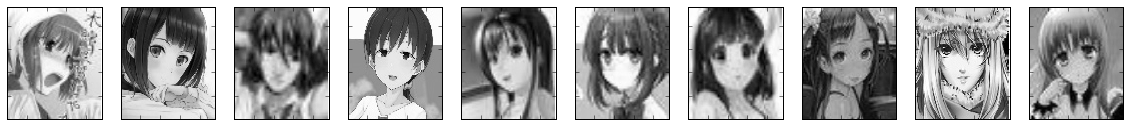

reconstruction image


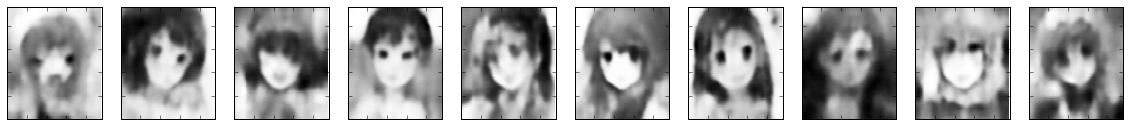

In [24]:
## 描画テスト (Open test) 
test_ind = np.random.permutation(N_test)[:10]
print test_ind
test = chainer.Variable(xp.asarray(x_test[test_ind]), volatile='on')
y = model(test)

print "input image"
draw_img_mc(x_test[test_ind])

print "reconstruction image"
draw_img_mc(y.data.get())

decode image from random vector


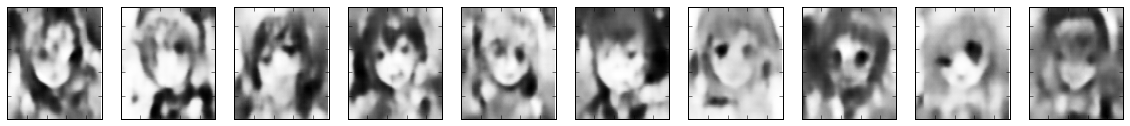

In [25]:
# draw images from randomly sampled z
z = chainer.Variable(xp.random.normal(0, 1, (10, n_latent)).astype(np.float32))
x = model.decode(z)
print "decode image from random vector"
draw_img_mc(x.data.get())

## Convolution層のフィルタを可視化

In [38]:
def draw_img_filter(data):
    size = data.shape[3]
    n = data.shape[0]
    n_col = int(math.ceil(n / 15)+1)
    img_data = data.get()
    plt.figure(figsize=(10*2, n_col*2))
    img_data /= img_data.max()
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(n_col, 15, cnt)
        tmp = img_data[idx,:,:,:].transpose(1,2,0)
        plt.imshow(tmp)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()

def draw_img_filter_mc(data, size=4):
    size = size
    n = data.shape[0]
    n_col = int(math.ceil(n / 15)+1)
    img_data = data.get()
    plt.figure(figsize=(10*2, n_col*2))
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(n_col, 15, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = img_data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]             # flip vertical
        plt.xlim(0,size)
        plt.ylim(0,size)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()

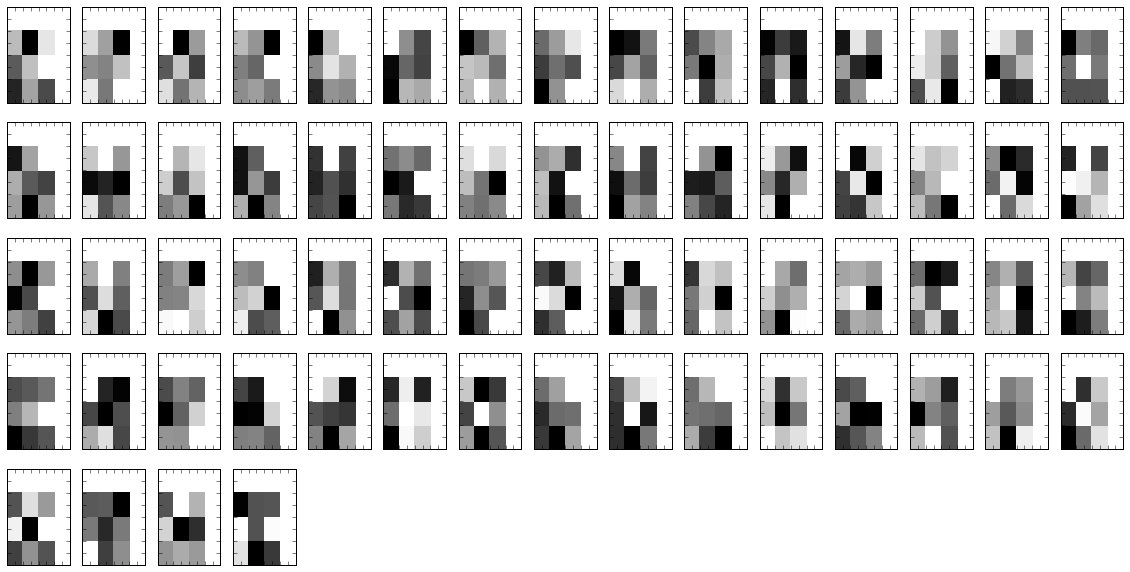

In [39]:
# 入力層側
draw_img_filter_mc(model.c0.W.data, size=4)

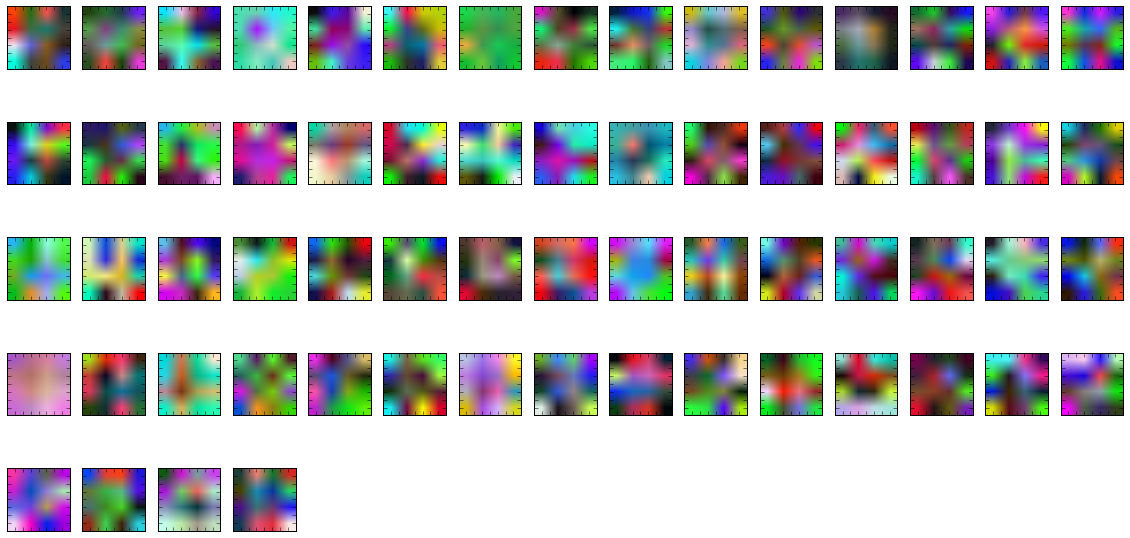

In [123]:
# 出力層側
draw_img_filter(model.dc4.W.data)